In [ ]:
!pip install --upgrade datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [ ]:
from datasets import load_dataset

ds = load_dataset("aquib1011/maize-leaf-disease")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/617 [00:00<?, ?B/s]

(…)-00000-of-00001-3b1e0906129238be.parquet:   0%|          | 0.00/124M [00:00<?, ?B/s]

(…)-00000-of-00001-b481d86c0eb10759.parquet:   0%|          | 0.00/45.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3350 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/838 [00:00<?, ? examples/s]

In [ ]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 3350
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 838
    })
})


In [ ]:
sample = ds['train'][0]
print(sample)

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7DAA10AFB110>, 'label': 3}


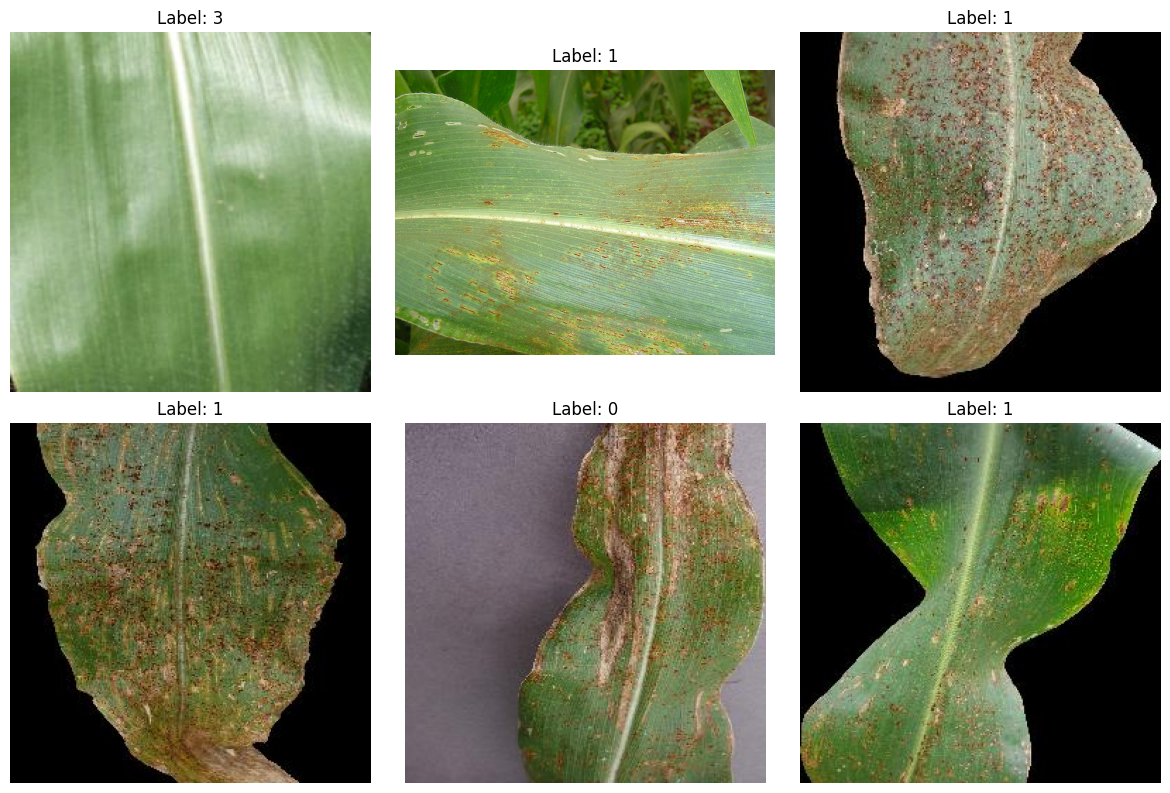

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    img = ds['train'][i]['image']
    label = ds['train'][i]['label']
    ax.imshow(img)
    ax.set_title(f"Label: {label}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
print(ds['train'].features)

{'image': Image(mode=None, decode=True), 'label': ClassLabel(names=['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy'])}


In [ ]:
print(ds['train'].features['label'].names)

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']


In [ ]:
num_classes = len(ds['train'].features['label'].names)
num_classes

4

In [ ]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
img = transform(ds['train'][0]['image'])

In [ ]:
from torch.utils.data import Dataset
from PIL import Image

class MaizeDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        label = item['label']

        if image.mode != 'RGB':
            image = image.convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
train_dataset = MaizeDataset(ds['train'], transform=transform)

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
import torchvision.models as models
import torch.nn as nn

model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_classes = len(ds['train'].features['label'].names)
model.fc = nn.Linear(model.fc.in_features, num_classes)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 180MB/s]


In [ ]:
import torch
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(5):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}")

Epoch 1, Loss: 18.7382
Epoch 2, Loss: 17.9975
Epoch 3, Loss: 18.1970
Epoch 4, Loss: 17.5519
Epoch 5, Loss: 17.7306


In [ ]:
val_dataset = MaizeDataset(ds['test'], transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32)

In [ ]:
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [ ]:
accuracy

np.float64(91.05011933174224)

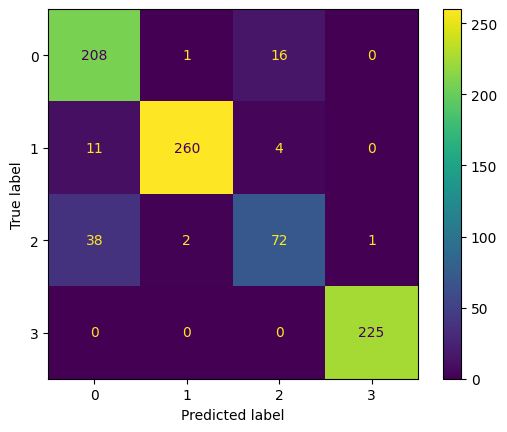

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [ ]:
from PIL import Image

img = Image.open("/content/maize_leaf_blight.jpg").convert("RGB")

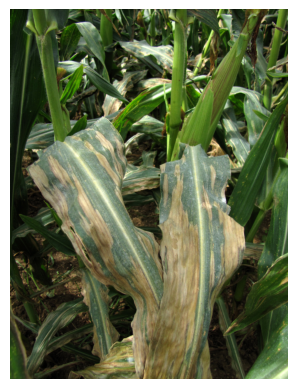

In [ ]:
plt.imshow(img)
plt.axis("off")
plt.show()

In [ ]:
transform(img)

tensor([[[-1.8782, -1.8097, -1.6384,  ..., -1.0562, -1.3130, -1.3473],
         [-1.8953, -1.7754, -1.6898,  ..., -1.1075, -1.3473, -1.2274],
         [-1.8782, -1.7925, -1.8097,  ..., -1.1418, -1.2959, -1.0390],
         ...,
         [-1.0904, -1.2959, -1.2959,  ...,  1.5468,  1.4269,  1.1872],
         [-1.2274, -1.2959, -1.2274,  ...,  1.2385,  1.0159,  0.7591],
         [-1.2788, -1.3130, -1.2617,  ...,  0.9474,  0.6563,  0.5193]],

        [[-1.5280, -1.3880, -1.0378,  ..., -0.4426, -0.7752, -0.8452],
         [-1.5630, -1.2654, -1.0378,  ..., -0.5301, -0.7927, -0.7052],
         [-1.5280, -1.2304, -1.1779,  ..., -0.6001, -0.7927, -0.5476],
         ...,
         [-0.4076, -0.7227, -0.7577,  ...,  2.0784,  1.9559,  1.7108],
         [-0.5301, -0.7227, -0.7052,  ...,  1.7808,  1.5707,  1.3256],
         [-0.5651, -0.7052, -0.7227,  ...,  1.5007,  1.2731,  1.2206]],

        [[-1.6999, -1.6650, -1.6650,  ..., -1.3339, -1.4210, -1.4210],
         [-1.6999, -1.6999, -1.6999,  ..., -1

In [ ]:
img_tensor = transform(img).unsqueeze(0)

model.eval()
with torch.no_grad():
    img_tensor = img_tensor.to(device)
    outputs = model(img_tensor)
    _, predicted_class = torch.max(outputs, 1)

class_names = ds['train'].features['label'].names
predicted_label = class_names[predicted_class.item()]
predicted_label

'Blight'

In [ ]:
for epoch in range(5):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)

    train_acc = evaluate(model, train_loader, device)

    val_acc = evaluate(model, val_loader, device)

    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

Epoch 1 | Loss: 0.1595 | Train Acc: 94.30% | Val Acc: 91.17%
Epoch 2 | Loss: 0.1526 | Train Acc: 95.97% | Val Acc: 92.36%
Epoch 3 | Loss: 0.1524 | Train Acc: 95.97% | Val Acc: 92.00%
Epoch 4 | Loss: 0.1630 | Train Acc: 94.60% | Val Acc: 91.05%
Epoch 5 | Loss: 0.1535 | Train Acc: 96.06% | Val Acc: 92.12%
